## Libraries

In [1]:
# Import the data science stack
import numpy as np
import pandas as pd
#import tensorflow as tf
import pickle
import time
from collections import defaultdict

from sklearn.utils import shuffle

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# File system access
import os

# Image importing
import csv
import cv2

# Tracking progress
from tqdm import tqdm

# Random seed
np.random.seed(2021)

#Sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix

In [2]:
#PyTorch
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, WeightedRandomSampler
import torch.nn.functional as F
device = torch.device("cuda")

In [4]:
# directory for the numpy data files
folder = '/home/ubuntu/data/numpy-files/'

## Build Model Functions

In [5]:
class CNN(nn.Module):
    
    def __init__(self,
                 filter_sizes,
                 num_filters,
                 fc1_neurons,
                 fc2_neurons):

        super(CNN, self).__init__()

        # Conv Network
        # creates a list of nn.Modules that are not connected
        # in this case the modules are different convolution layers
        self.conv2d_list = nn.ModuleList([          
            nn.Conv2d(in_channels=1, 
                      out_channels=num_filters[i],  # number of output features
                      kernel_size=filter_sizes[i])  # size of filter
            for i in range(len(filter_sizes))
        ])
        
        # RELU activation function
        self.relu =  nn.ReLU()   

        # Fully-connected layers
        self.fc1 = nn.Linear(np.sum(num_filters), fc1_neurons)  

        if fc2_neurons != None:

            # print('fc2=None')     
                       
            self.fc2 = nn.Linear(fc1_neurons, fc2_neurons)

            self.fc3 = nn.Linear(fc2_neurons, 3)

        else:
                       
            self.fc2 = nn.Linear(fc1_neurons, 3)
                    
        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs):

        # Apply CNN and ReLU to each convolution layer
        x_conv_list = [self.relu(conv2d(inputs)) for conv2d in self.conv2d_list]



        # Max poolin to the outputs of ReLU
        # shape = (batch_size, channel, width, height)
        x_pool_list = [F.max_pool2d(x_conv, kernel_size=x_conv.shape[2])
            for x_conv in x_conv_list]
        
        # print(x_pool_list[0].shape)
        # print(x_pool_list[0].squeeze(32).shape)
        # print(x_pool_list[0].squeeze(3).shape)
        # Concatenate x_pool_list to feed the fully connected layer
        x_fc = torch.cat([x_pool.squeeze(2).squeeze(2) for x_pool in x_pool_list],
                         dim=1)

        x = self.fc1(x_fc)              
        x = self.relu(x)

        x = self.fc2(x)

        try:
            if self.fc3 != None:
            
                x = self.relu(x)
                x = self.fc3(x)

        except:
            pass

        
        probs = self.softmax(x) 

        return probs

In [6]:
def train_CNN(model, optimizer, train_dataloader, epochs, run_number, 
          val_dataloader=None, save_run=None, return_progress_dict = None, hide_text = None):
    
    # Tracking lowest validation loss
    lowest_val_loss = float('inf')
    if return_progress_dict == 'Yes':
        progress_dict = {run_number: {'Epoch':[], 'Avg_Training_Loss':[], 'Validation_Loss':[], 'Validation_Accuracy':[]} }

    # Start training loop
    if hide_text != "Yes":
        print("Start training...\n")
        print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*60)

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        # Tracking time and loss
        t0_epoch = time.time()
        total_loss = 0

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            # Load batch to CPU
            data, labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            optimizer.zero_grad()

            # Perform a forward pass. This will return logits.
            probs = model(data)

            # Compute loss and accumulate the loss values
            loss = cross_entropy(probs, labels)
            
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Update parameters
            optimizer.step()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        if return_progress_dict == 'Yes':
            progress_dict[run_number]['Avg_Training_Loss'].append(avg_train_loss)
            progress_dict[run_number]['Epoch'].append(epoch_i)

        # =======================================
        #               Evaluation
        # =======================================
        if val_dataloader is not None:
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
            val_loss, val_accuracy, _, _, _ = evaluate_CNN(model, val_dataloader)
            if return_progress_dict == 'Yes':
                progress_dict[run_number]['Validation_Loss'].append(val_loss)
                progress_dict[run_number]['Validation_Accuracy'].append(val_accuracy)


            # Track the lowese validation loss and save the weights of the model for that epoch
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                if save_run == 'Yes':
                    torch.save(model.state_dict(), 'CNN_Weights_Run_'+str(run_number))

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            if hide_text != "Yes":
                print(f"{epoch_i + 1:^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
    if save_run == 'Yes':
          pickle.dump(progress_dict, open( 'trainig_dict_CNN_Run_'+str(run_number), "wb" ) )
    
    if hide_text != "Yes":         
        print("\n")
        print(f"Training complete! Lowest Validation Loss: {lowest_val_loss:.2f}.")
    if return_progress_dict == 'Yes':
        return progress_dict

In [7]:
def evaluate_CNN(model, val_dataloader):
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []
    total_probs = []
    total_preds = []
    total_labels = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to CPU
        data, labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            probs = model(data)
            
        total_probs.append(probs)

        # Compute loss
        loss = cross_entropy(probs, labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(probs, dim=1).flatten()
        total_preds.append(preds)
        total_labels.append(labels)

        # Calculate the accuracy rate
        accuracy = (preds == labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy, total_probs, total_preds, total_labels

## Train

Takes 2 minutes.  Note, the respective data files are loaded in their sections to prevent OOM.

In [8]:
train_X = np.load(folder +'train_X.npy')
train_y = np.load(folder +'train_y.npy')

val_X = np.load(folder +'val_X.npy')
val_y = np.load(folder +'val_y.npy')

Convert to tensor, outputs 4D tensor.

In [9]:
train_X = train_X.reshape(len(train_X), 1, 256, 256)
val_X = val_X.reshape(len(val_X), 1, 256, 256)

In [10]:
# for train set
train_seq_CNN = torch.from_numpy(train_X).float()
train_y_CNN = torch.tensor(train_y).type(torch.LongTensor)

In [11]:
# for validation set
val_seq_CNN = torch.from_numpy(val_X).float()
val_y_CNN = torch.tensor(val_y).type(torch.LongTensor)

In [12]:
train_data_CNN = TensorDataset(train_seq_CNN, train_y_CNN)

In [13]:
val_data_CNN = TensorDataset(val_seq_CNN, val_y_CNN)

In [14]:
# confirm 4D tensor
train_seq_CNN.shape

torch.Size([136445, 1, 256, 256])

Convert to TensorDataset and Create DataLoader

In [15]:
# Wrap tensors and create dataloaders
# Creating a batch size of 150 in order to ensure at least one example of each class is included.
batch_size = 150

In [16]:
train_sampler_CNN = RandomSampler(train_data_CNN)
train_dataloader_CNN = DataLoader(train_data_CNN, sampler=train_sampler_CNN, batch_size=batch_size)

In [17]:
val_sampler_CNN = SequentialSampler(val_data_CNN)
val_dataloader_CNN = DataLoader(val_data_CNN, sampler = val_sampler_CNN, batch_size=batch_size)

Model

In [18]:
# device = torch.device("cuda")
device = torch.device('cuda')
pandas_list = []

#computing class weights due to imbalanced dataset
class_wts = compute_class_weight('balanced', np.unique(np.array(train_y_CNN)), np.array(train_y_CNN))
class_wts = torch.tensor(class_wts,dtype=torch.float)
class_wts = class_wts.to(device)

# loss function
cross_entropy = nn.CrossEntropyLoss(weight=class_wts)

/home/ubuntu/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [19]:
#Model Initializiation
CNN_Model = CNN(filter_sizes = [2, 3, 4], 
                num_filters = [25,25,25],
                fc1_neurons = 200,
                fc2_neurons = 50
                )

# push the model to GPU
CNN_Model = CNN_Model.to(device)

In [20]:
optimizer = torch.optim.Adam(CNN_Model.parameters())
epochs = 50
run_number = 1

Run training

In [21]:
Training_Dict = train_CNN(model = CNN_Model, 
                  optimizer = optimizer, 
                  train_dataloader = train_dataloader_CNN, 
                  epochs = epochs,
                  run_number = run_number,
                  val_dataloader = val_dataloader_CNN,
                  save_run = 'Yes',
                  return_progress_dict = 'Yes',
                  hide_text = 'No')

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |   0.704884   |  0.558972  |   80.48   |  206.20  
   2    |   0.462233   |  0.404568  |   86.51   |  189.53  
   3    |   0.402896   |  0.348925  |   87.28   |  189.52  
   4    |   0.351791   |  0.317073  |   88.56   |  189.36  
   5    |   0.324809   |  0.326913  |   87.20   |  189.35  
   6    |   0.308756   |  0.286914  |   90.15   |  189.31  
   7    |   0.283823   |  0.269457  |   90.65   |  189.44  
   8    |   0.267749   |  0.266368  |   89.87   |  189.37  
   9    |   0.254795   |  0.227158  |   92.12   |  189.46  
  10    |   0.238414   |  0.251842  |   91.05   |  189.46  
  11    |   0.228017   |  0.202861  |   92.26   |  189.33  
  12    |   0.215696   |  0.203738  |   92.87   |  189.39  
  13    |   0.207789   |  0.220797  |   91.96   |  189.41  
  14    |   0.202093   |  0.199223  |   93.17   |  189.60  
  15    |   0.193085

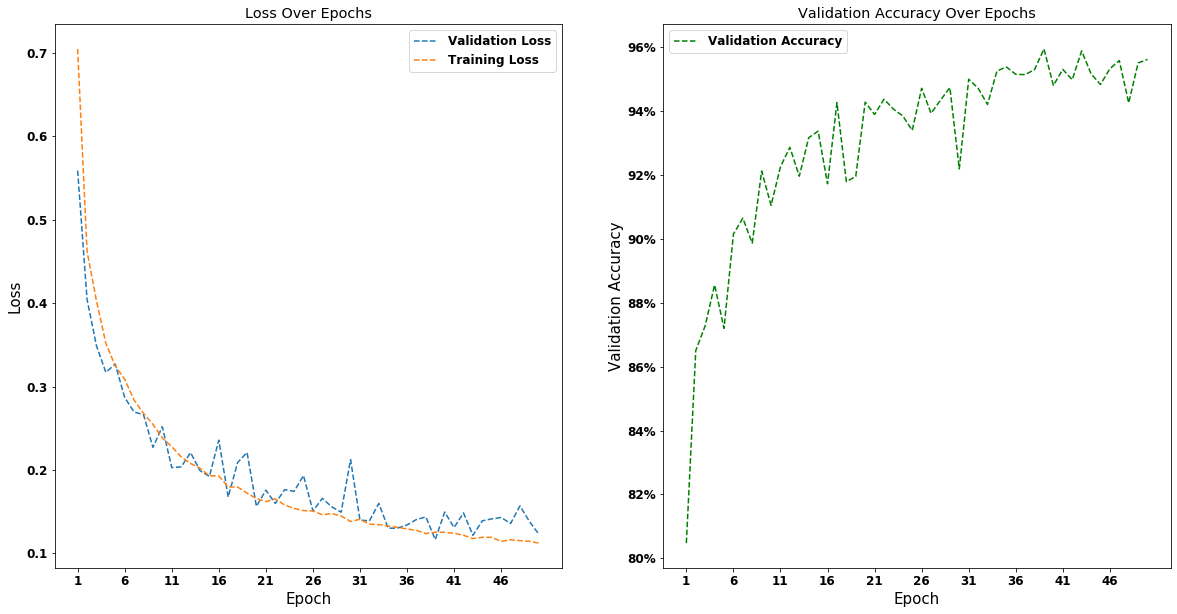

In [30]:
#Graph Option 2
#Plotting Validation Loss With Respect to Training Epochs
from matplotlib.ticker import PercentFormatter


font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(1,2)

epoch_list = Training_Dict[1]['Epoch']
Avg_Training_Loss_List = Training_Dict[1]['Avg_Training_Loss']
Validation_Loss_List = Training_Dict[1]['Validation_Loss']
Validation_Accuracy_List = Training_Dict[1]['Validation_Accuracy']

epoch_list_adj = [x+1 for x in epoch_list]

fig.set_figheight(10)
fig.set_figwidth(20)

ax1.plot(epoch_list_adj, Validation_Loss_List, linestyle='--',  label='Validation Loss')
ax1.plot(epoch_list_adj, Avg_Training_Loss_List, linestyle='--',  label='Training Loss')
ax1.set_ylabel('Loss', size = 15)
ax1.set_xlabel('Epoch', size = 15)
# ax1.set_xticks(epoch_list_adj)
ax1.set_xticks(np.arange(min(epoch_list_adj), max(epoch_list_adj)+1, 5))
ax1.set_title('Loss Over Epochs')
ax1.legend()

ax2.plot(epoch_list_adj, Validation_Accuracy_List, linestyle='--',  label='Validation Accuracy', color='green')
ax2.set_ylabel('Validation Accuracy', size = 15)
ax2.set_xlabel('Epoch', size = 15)
ax2.set_xticks(np.arange(min(epoch_list_adj), max(epoch_list_adj)+1, 5))
# plt.xticks(np.arange(min(x), max(x)+1, 1.0))
ax2.yaxis.set_major_formatter(PercentFormatter(decimals=0))
ax2.set_title('Validation Accuracy Over Epochs')
ax2.legend()

plt.show()

## Test

Load test files to dataloader

In [31]:
test_X = np.load(folder +'test_X.npy')
test_y = np.load(folder +'test_y.npy')

In [32]:
test_X = test_X.reshape(len(test_X), 1, 256, 256)

In [33]:
test_seq_CNN = torch.from_numpy(test_X).float()
test_y_CNN = torch.tensor(test_y).type(torch.LongTensor)

In [34]:
test_data_CNN = TensorDataset(test_seq_CNN, test_y_CNN)
test_sampler_CNN = RandomSampler(test_data_CNN)
test_dataloader_CNN = DataLoader(test_data_CNN, sampler=test_sampler_CNN, batch_size=batch_size)

Perform evaluation

In [67]:
#load weights of best model
CNN_Model.load_state_dict(torch.load('/home/ubuntu/CNN_Weights_Run_1'))

<All keys matched successfully>

In [35]:
# run prediction and evaluation
test_loss_CNN, test_accuracy_CNN, \
total_probs_CNN, total_preds_CNN, \
total_labels_CNN = evaluate_CNN(model = CNN_Model, 
                                val_dataloader = test_dataloader_CNN)

In [36]:
# 
total_labels_CNN_Cat = torch.cat(total_labels_CNN).cpu().numpy()
total_probs_CNN_Cat = torch.cat(total_probs_CNN).cpu().numpy()
total_preds_CNN_Cat = torch.cat(total_preds_CNN).cpu().numpy()

In [37]:
print('Test Loss:', test_loss_CNN)
print('Test Accuracy:', test_accuracy_CNN)
print('\n')
print(classification_report(total_labels_CNN_Cat, total_preds_CNN_Cat))

Test Loss: 0.11931308439144721
Test Accuracy: 95.71022029613579


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6032
           1       0.95      0.94      0.94      4027
           2       1.00      0.95      0.97      9433

    accuracy                           0.96     19492
   macro avg       0.95      0.96      0.95     19492
weighted avg       0.96      0.96      0.96     19492



## Hyperparameter Tuning

Note: may encounter OOM.  Hyperparameter tuning part might need to be run separately from training on fresh kernel.

Load in hyperparameter dataset

In [8]:
hyper_X = np.load(folder + 'hyper_X.npy')
hyper_y = np.load(folder + 'hyper_y.npy')

In [9]:
hyper_X = hyper_X.reshape(len(hyper_X), 1, 256, 256)

In [10]:
hyper_seq_CNN = torch.from_numpy(hyper_X).float()
hyper_y_CNN = torch.tensor(hyper_y).type(torch.LongTensor)

In [11]:
batch_size = 150
hyper_data_CNN = TensorDataset(hyper_seq_CNN, hyper_y_CNN)
hyper_sampler_CNN = RandomSampler(hyper_data_CNN)
hyper_dataloader_CNN = DataLoader(hyper_data_CNN, sampler=hyper_sampler_CNN, batch_size=batch_size)

Load in validation dataset

In [12]:
val_X = np.load(folder +'val_X.npy')
val_y = np.load(folder +'val_y.npy')

In [13]:
val_X = val_X.reshape(len(val_X), 1, 256, 256)

In [14]:
val_seq_CNN = torch.from_numpy(val_X).float()
val_y_CNN = torch.tensor(val_y).type(torch.LongTensor)

In [15]:
val_data_CNN = TensorDataset(val_seq_CNN, val_y_CNN)
val_sampler_CNN = SequentialSampler(val_data_CNN)
val_dataloader_CNN = DataLoader(val_data_CNN, sampler = val_sampler_CNN, batch_size=batch_size)

Model

In [16]:
#Model Initializiation
CNN_Model = CNN(filter_sizes = [2, 3, 4], 
                num_filters = [25,25,25],
                fc1_neurons = 100,
                fc2_neurons = None
                )

# push the model to GPU
CNN_Model = CNN_Model.to(device)

Scan hyperparameters

In [18]:
device = torch.device("cuda")

pandas_list = []

#computing class weights due to imbalanced dataset
class_wts = compute_class_weight('balanced', np.unique(np.array(hyper_y_CNN)), np.array(hyper_y_CNN))
class_wts = torch.tensor(class_wts,dtype=torch.float)
class_wts = class_wts.to(device)

# loss function
cross_entropy = nn.CrossEntropyLoss(weight=class_wts)

HYPERPARAMETER_SELECTION = 0


#Hyperparameters for Tuning
filter_sizes=[[2, 3, 4], [3, 4, 5]]
num_filters= [25, 50, 100]
fc1_neurons = [200, 500]
fc2_neurons = [None, 50, 100]
# dropout = [0.4, 0.5]
optimizer_list = ['Adam','RMSprop']

num_iterations = len(filter_sizes)*len(num_filters)*len(fc1_neurons)*len(fc2_neurons)*len(optimizer_list)


for i in filter_sizes:
    for j in num_filters:
        j = [j] * len(i)
        for k in fc1_neurons:
            for l in fc2_neurons:         
                for n in optimizer_list:           
                # for n in range(len(optimizer_list)):
                #     q = optimizer_list[n]
                #     if q == 0:
                #         Optimizer_Name = 'Adam'
                #     else:
                #         Optimizer_Name = 'RMSprop'
                    #Model Initializiation
                    Hyper_CNN_Model = CNN(filter_sizes = i, 
                                    num_filters = j, 
                                    fc1_neurons = k, 
                                    fc2_neurons = l, 
                                    # dropout = m
                                    )

                    # push the model to CPU
                    device = torch.device('cuda')
                    Hyper_CNN_Model = CNN_Model.to(device)

                    # define the optimizer
                    if n == 'Adam':
                        optimizer = torch.optim.Adam(Hyper_CNN_Model.parameters())
                    else:
                        optimizer = torch.optim.RMSprop(Hyper_CNN_Model.parameters())
                    
                    epochs = 1
                    run_number = 1

                    training_dict = train_CNN(model = Hyper_CNN_Model, 
                                              optimizer = optimizer, 
                                              train_dataloader = hyper_dataloader_CNN, 
                                              epochs = epochs,
                                              run_number = run_number,
                                              val_dataloader=val_dataloader_CNN,
                                              save_run = 'No',
                                              return_progress_dict = 'Yes',
                                              hide_text = 'Yes')
                    
                    for o in range(epochs):
                        EPOCH = training_dict[run_number]['Epoch'][o]
                        AVERAGE_TRAINING_LOSS = training_dict[run_number]['Avg_Training_Loss'][o]
                        VALIDATION_LOSS = training_dict[run_number]['Validation_Loss'][o]
                        VALIDATION_ACCURACY = training_dict[run_number]['Validation_Accuracy'][o]
                        
                        pandas_list.append([HYPERPARAMETER_SELECTION,
                                            EPOCH,
                                            i,
                                            j,
                                            k,
                                            l,
                                            # n,
                                            n,
                                            AVERAGE_TRAINING_LOSS,
                                            VALIDATION_LOSS,
                                            VALIDATION_ACCURACY,
                                            ])
                        
                    HYPERPARAMETER_SELECTION += 1
                    
                    print(HYPERPARAMETER_SELECTION,'of',num_iterations,'Iterations Complete.' )

summary_CNN = pd.DataFrame(pandas_list, columns = ['HYPERPARAMETER SELECTION',
                                               'EPOCH',
                                               'KERNEL SIZES',
                                               'NUMBER OF FILTERS',
                                               'FIRST HIDDEN LAYER DIMENSIONS',
                                               'SECOND HIDDEN LAYER DIMENSION',
                                              #  'DROPOUT',
                                               'OPTIMIZER',
                                               'AVERAGE TRAINING LOSS',
                                               'VALIDATION LOSS',
                                               'VALIDATION ACCURACY'
                                              ]).sort_values('VALIDATION LOSS')


1 of 72 Iterations Complete.
2 of 72 Iterations Complete.
3 of 72 Iterations Complete.
4 of 72 Iterations Complete.
5 of 72 Iterations Complete.
6 of 72 Iterations Complete.
7 of 72 Iterations Complete.
8 of 72 Iterations Complete.
9 of 72 Iterations Complete.
10 of 72 Iterations Complete.
11 of 72 Iterations Complete.
12 of 72 Iterations Complete.
13 of 72 Iterations Complete.
14 of 72 Iterations Complete.
15 of 72 Iterations Complete.
16 of 72 Iterations Complete.
17 of 72 Iterations Complete.
18 of 72 Iterations Complete.
19 of 72 Iterations Complete.
20 of 72 Iterations Complete.
21 of 72 Iterations Complete.
22 of 72 Iterations Complete.
23 of 72 Iterations Complete.
24 of 72 Iterations Complete.
25 of 72 Iterations Complete.
26 of 72 Iterations Complete.
27 of 72 Iterations Complete.
28 of 72 Iterations Complete.
29 of 72 Iterations Complete.
30 of 72 Iterations Complete.
31 of 72 Iterations Complete.
32 of 72 Iterations Complete.
33 of 72 Iterations Complete.
34 of 72 Iterations

In [21]:
summary_CNN.head(10)

,HYPERPARAMETER SELECTION,EPOCH,KERNEL SIZES,NUMBER OF FILTERS,FIRST HIDDEN LAYER DIMENSIONS,SECOND HIDDEN LAYER DIMENSION,OPTIMIZER,AVERAGE TRAINING LOSS,VALIDATION LOSS,VALIDATION ACCURACY
2,2,0,"[2, 3, 4]","[25, 25, 25]",200,50.0,Adam,0.832745,0.781840,65.779848
4,4,0,"[2, 3, 4]","[25, 25, 25]",200,100.0,Adam,0.865472,0.849433,66.567064
0,0,0,"[2, 3, 4]","[25, 25, 25]",200,NaN,Adam,1.645104,0.879331,62.911448
6,6,0,"[2, 3, 4]","[25, 25, 25]",500,NaN,Adam,0.923998,0.881820,64.067895
8,8,0,"[2, 3, 4]","[25, 25, 25]",500,50.0,Adam,0.900638,0.899858,57.777537
12,12,0,"[2, 3, 4]","[50, 50, 50]",200,NaN,Adam,0.933332,0.922048,63.020585
10,10,0,"[2, 3, 4]","[25, 25, 25]",500,100.0,Adam,0.926332,0.924838,56.479234
7,7,0,"[2, 3, 4]","[25, 25, 25]",500,NaN,RMSprop,1.307246,0.937304,43.780282
3,3,0,"[2, 3, 4]","[25, 25, 25]",200,50.0,RMSprop,3.687932,0.945084,64.993283
9,9,0,"[2, 3, 4]","[25, 25, 25]",500,50.0,RMSprop,1.893101,0.955423,55.514554


## Inference

Load test data

In [23]:
# load numpy files
test_X = np.load(folder + 'test_X.npy')
test_y = np.load(folder + 'test_y.npy')

In [42]:
# select a few images for each class
Normal_Index = np.where(test_y==0)[0][0:3]
Pneumonia_Index = np.where(test_y==1)[0][0:3]
Covid_Index = np.where(test_y==1)[0][0:3]

Normal_Images = test_X[Normal_Index]
Pneumonia_Images = test_X[Pneumonia_Index]
Covid_Images = test_X[Covid_Index]

In [57]:
def predict_CNN(model, image):
  
    """After the completion of each training epoch, measure the model's
    performance on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled
    # during the test time.
    model.eval()

    image_reshaped = torch.from_numpy(image.reshape(1,1,256,256)).float().cuda()

    # Compute logits
    with torch.no_grad():
        probs = model(image_reshaped)
            
        # Get the predictions
        prediction = torch.argmax(probs, dim=1).flatten()

    if prediction == 0:
        prediction_label = 'Diagnosis: Normal'
    elif prediction == 1:
        prediction_label = 'Diagnosis: Pneumonia'
    else:
        prediction_label = 'Diagnosis: COVID-19'

    return (prediction_label, '; Probability of Diagnosis: %0.2f' %np.exp(probs[0][prediction][0].cpu().item()) )

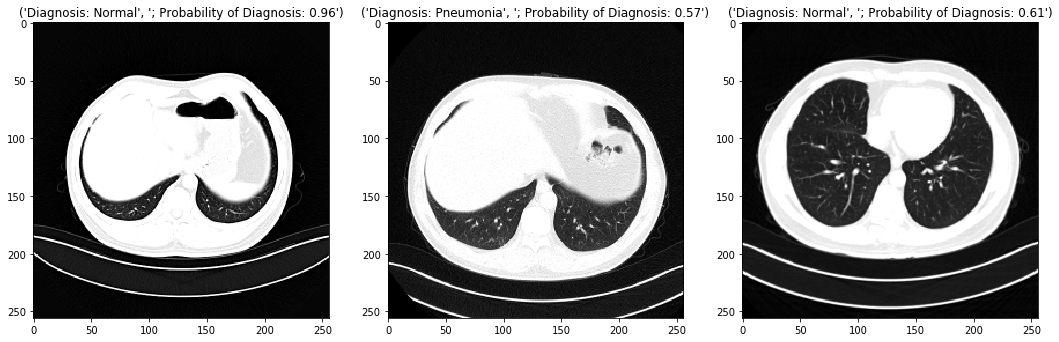

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i,image in enumerate(Normal_Images):
    results = predict_CNN(CNN_Model, image)
    axes[i].imshow(image, cmap='gray')        
    axes[i].set_title(results)

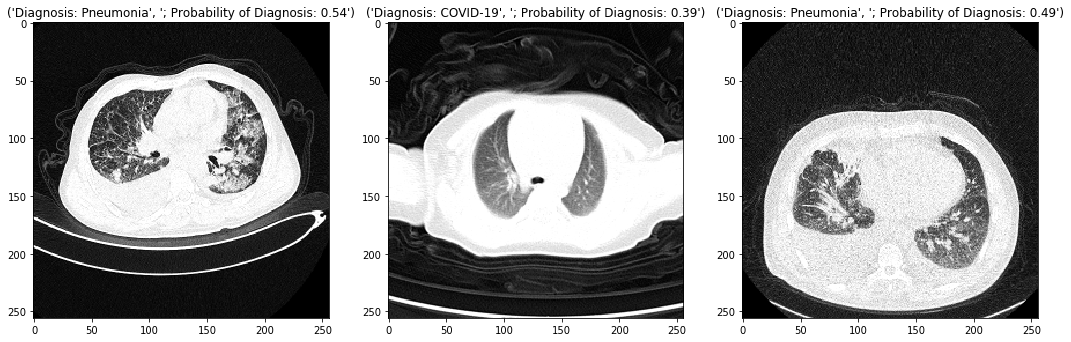

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i,image in enumerate(Pneumonia_Images):
    results = predict_CNN(CNN_Model, image)
    axes[i].imshow(image, cmap='gray')        
    axes[i].set_title(results)

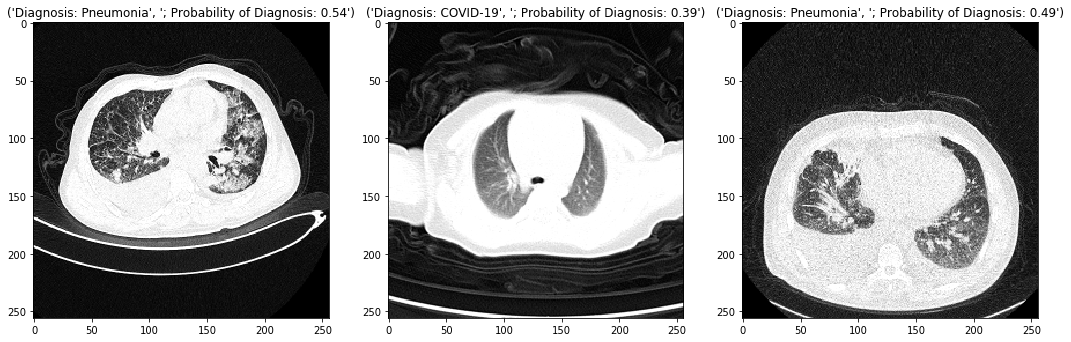

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i,image in enumerate(Covid_Images):
    results = predict_CNN(CNN_Model, image)
    axes[i].imshow(image, cmap='gray')        
    axes[i].set_title(results)